In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [179]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import scipy as si
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
sns.set_style("whitegrid")
sns.set_context("poster")

# Engineering Science 201: Decision Theory Final Project: Predicting Gentrification With Spatial Modeling
### May 7, 2018
### Michael Giles and Emma He
## Introduction

In recent history, gentrification has grown into an increasingly charged phenomenon, as wealthier individuals and developers capitalize on the culture of low-income neighborhoods and as a result displace the lifelong residents of those neighborhoods. The issue is particularly charged in New York City, where many feel enraged that the people who create the culture of the city can no longer afford to live there. Gentrification is not only an issue of economic inequalities but also racial 

## Data Sources

We used data provided by New York City's [Furman Center](http://coredata.nyc/). The data consisted of yearly measurements of 7 variables of interest from 2005-2016:
* Median Rent
* Median Income
* Educational Attainment
* Ratio of residents who are white or primarily white
* Proportion of residential units within 0.5 miles of subway station in 2016
* Permits issued for new residential unit construction in the past year
* Violent Crimes per 1,000 people

The first 4 features were aggregated by the 55 federally-defined Public Use Microdata Areas (PUMAs), elsewhere called Sub-Borough-Areas (SBAs) in New York City, whereas the last 3 features were aggregated by the 59 Community Districts (CDs) defined by the city itself. For the most part, the boundaries of the two coincide. However, 4 PUMAs were created by merging 4 pairs of community districts. To obtain our last two data points in terms of the first two, we merged the four pairs of Community Districts into their corresponding PUMAs via a weighted average of the relevant population of each, weighting the new unit construction by the total number of residential units in each CD and the violent crime rate by the total population of each CD, which we obtained from the 2010 census. Crime statistics for 2005 were missing -- we filled in values using data from 2006 and used linear interpolation to fill in missing values in the crime statistics and new apartment units statistics.

In [99]:
# merge puma codes with sub-bourough data
years = [str(y) for y in range(2005,2017)]
puma_cd_name = pd.read_csv('../data/PUMA_CD_NAME.csv',index_col = 0)
median_rents = pd.read_csv('../data/sub-borougharea-medianrentall2016.csv')
median_rents = median_rents.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_rents = median_rents.set_index('puma')
median_rents = median_rents.sort_index()
median_incomes = pd.read_csv('../data/sub-borougharea-medianhouseholdincome2016.csv')
median_incomes = median_incomes.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_incomes = median_incomes.set_index('puma')
median_incomes = median_incomes.sort_index()
education_levels = pd.read_csv('../data/sub-borougharea-populationaged25withabachelorsdegreeorhigher.csv')
education_levels = education_levels.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
education_levels = education_levels.set_index('puma')
education_levels = education_levels.sort_index()
percents_white = pd.read_csv('../data/sub-borougharea-percentwhite.csv')
percents_white = percents_white.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
percents_white = percents_white.set_index('puma')
percents_white[years] = percents_white[years].interpolate(method='linear', axis = 0)
percents_white = percents_white.sort_index()
nyc_median_incomes = pd.read_csv('../data/city-medianhouseholdincome2016.csv')
nyc_median_rents = pd.read_csv('../data/city-medianrentall2016.csv')
subways = pd.read_csv('../data/communitydistrict-residentialunitswithin12mileofasubwaystation.csv')

In [100]:
subways['cd'], subways['CD_Name'] = subways['Community District'].str.split(" - ",1).str
subways['cd'] = subways['cd'].str.replace(" ", "")

In [101]:
# # Merge community district data into PUMAs based on 2010 census
housing_units = pd.read_csv('../data/community_district_housing_units2010.csv')
housing_units['cd'] = housing_units['Community_District'].str.lstrip()
housing_units['cd'] = housing_units['cd'].str.rstrip()
housing_units['Borough'], housing_units['CD_Number'] = housing_units['cd'].str.split(" ",1).str
housing_units['CD_Number']= housing_units['CD_Number'].str.zfill(2)
housing_units['cd'] = housing_units['Borough'] + housing_units['CD_Number']
housing_units = housing_units[['cd', 'Units']]
housing_units['Units'] = housing_units['Units'].str.replace(',','').astype('int64')

In [102]:
population = pd.read_csv('../data/community_district_population2010.csv')
population['cd'] = population['Community_District'].str.lstrip()
population['cd'] = population['cd'].str.rstrip()
population['Borough'], population['CD_Number'] = population['cd'].str.split(" ",1).str
population['CD_Number']= population['CD_Number'].str.zfill(2)
population['cd'] = population['Borough'] + population['CD_Number']
population = population[['cd', 'Population']]

In [103]:
merging = [('BX01', 'BX02'), ('BX03', 'BX06'), ('MN01', 'MN02'), ('MN04', 'MN05')]
years = [str(y) for y in range(2005,2017)]

In [104]:
subways = subways[['cd', '2016']]
merged = []
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    newval = u *subways[subways['cd']==a]['2016'].values[0] + v * subways[subways['cd']==b]['2016'].values[0]
    newval = newval / float(denom)
    merged.append({
        'cd': a + b, 
        '2016': newval})
subways = subways.append(merged, ignore_index = True)
subways = subways.merge(puma_cd_name, on = 'cd', how = 'outer')
subways = subways.dropna(how='any')
subways['puma'] = subways['puma'].astype('int')
subways = subways.set_index('puma')
subways = subways.sort_index()
subways = pd.concat([subways['2016']]*12, axis=1)
subways.columns = years

In [105]:
new_units = pd.read_csv('../data/communitydistrict-unitsauthorizedbynewresidentialbuildingpermits.csv')
new_units['cd'], new_units['Name'] = new_units['Community District'].str.split(" - ",1).str
new_units['cd'] = new_units['cd'].str.replace(' ','')
years = [str(n) for n in range(2000,2017)]
indices = ['cd', 'Name'] + years
new_units = new_units[indices]
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    row1 = new_units[new_units['cd']==a][years].values
    row2 = new_units[new_units['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    new_units = new_units.append(newrow, ignore_index = True)
new_units = new_units.merge(puma_cd_name, on='cd', how='outer')
new_units = new_units[pd.notnull(new_units['CD_Name'])]
new_units['puma'] = new_units['puma'].astype('int64')
new_units = new_units.set_index('puma')
new_units[years] = new_units[years].interpolate(method='linear', axis = 0)
new_units = new_units.sort_index()

In [106]:
crime = pd.read_csv('../data/communitydistrict-seriouscrimerateper1000residents.csv')
crime['cd'], crime['CD_Name'] = crime['Community District'].str.split(" - ",1).str
crime['cd'] = crime['cd'].str.replace(' ','')
years = [str(n) for n in range(2006,2017)]
indices = ['cd'] + years
crime = crime[indices]
for i,(a,b) in enumerate(merging):
    u = float(population[population['cd']==a]['Population'].values[0])
    v = float(population[population['cd']==b]['Population'].values[0])
    denom = u + v
    row1 = crime[crime['cd']==a][years].values
    row2 = crime[crime['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    crime = crime.append(newrow, ignore_index = True)
crime = crime.merge(puma_cd_name, on='cd', how='outer')
crime = crime[pd.notnull(crime['CD_Name'])]
crime['puma'] = crime['puma'].astype('int64')
crime = crime.set_index('puma')
crime = crime.sort_index()

# horrendous and lazy way to fill in missing values
lineup = crime['2006'].values
crime.insert(0, '2005', lineup)

Here is an example of what our data looked like:

In [107]:
median_rents.head()

,short_name,long_name,Sub-Borough Area,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cd,CD_Name
puma,,,,,,,,,,,,,,,,,,
3701,gross_rent_adj,"Median rent, all ($2016)",Riverdale/Kingsbridge,1060,1090,1120,1140,1170,1200,1230,1240,1240,1290,1200,1310,1310,BX08,Riverdale/Kingsbridge
3702,gross_rent_adj,"Median rent, all ($2016)",Williamsbridge/Baychester,1000,1070,1100,1110,1120,1160,1150,1190,1200,1240,1220,1210,1250,BX12,Williamsbridge/Baychester
3703,gross_rent_adj,"Median rent, all ($2016)",Throgs Neck/Co-op City,950,990,1050,1020,1140,1070,1130,1150,1020,1110,1130,1070,1200,BX10,Throgs Neck/Co-op City
3704,gross_rent_adj,"Median rent, all ($2016)",Pelham Parkway,1000,1080,1040,1130,1080,1130,1140,1180,1200,1160,1240,1260,1270,BX11,Pelham Parkway
3705,gross_rent_adj,"Median rent, all ($2016)",Morrisania/Belmont,690,810,850,870,870,910,900,930,900,940,910,960,970,BX03BX06,Morrisania/Belmont


## Testing Our Features

To test the relevance of our features and to get an idea of their effect on the independent variable, we performed principal component analysis on each of the neighborhoods:

In [163]:
n = 12 # number of years
m = 6 # number of features
k = 55 # number of PUMAs
years = [str(y) for y in range(2005,2017)]

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values]
feature_labels = ['median_incomes', 'education_level', 'percent_white', 'subways', 'new_units', 'crime']

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

X = np.dstack(features)    
    
Y = median_rents[years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))

X_test = X[:,-2:,:]
Y_test = Y[:,-2:]
Y_train = Y[:,:-2]
X_train = X[:, :-2, :]

Principal component analysis (PCA) is a linear transformation of the data into an uncorrelated orthogonal basis composed of the principal components. Principal components are the orthogonal axes that account for the most variability within the data. The principal components are ordered by the amount of variability they capture, with the first principal component having the most variance. We used PCA to identify the most important features of each neighborhood to predict rent. Since our variables were measured on very different scales (0.3 vs 3000), it was important that we standardized our data by mean-subtracting and scaling to unit norm. 

In [164]:
pcas = np.zeros((k,m,m))
expratios = np.zeros((k,m))
pca = PCA()
for i in range(k):
    pca = pca.fit(X_train[i], Y_train[i])
    pcas[i] = pca.components_
    expratios[i] = pca.explained_variance_ratio_

The first three components explain about 90 percent of the variation in median rents for most neighborhoods, but it varies:

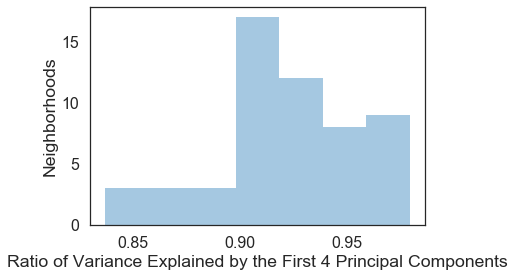

In [165]:
sns.distplot(expratios[:,:3].sum(axis=1), kde=False)
plt.xlabel('Ratio of Variance Explained by the First 3 Principal Components')
plt.ylabel('Neighborhoods')
plt.show()

We can look at the ways our features correlate with one another

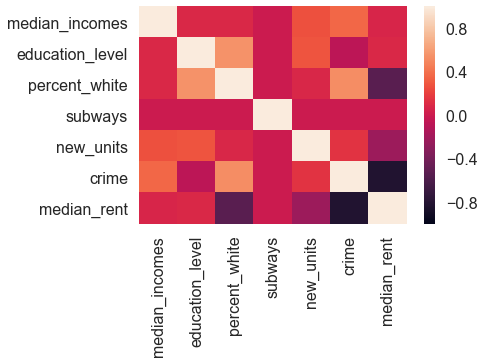

In [166]:
Cs = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
for i in range(1,k):
    m = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
    Cs=np.dstack([Cs,m])
sns.heatmap(Cs.mean(axis=2), xticklabels = feature_labels+['median_rent'], yticklabels = feature_labels + ['median_rent'], vmin = -1, vmax =1)
plt.show()

From this, it appears that our subways data is not heopful. We can get an idea of the importance of each of the features by summing up the weights given to each feature for each neighborhood in the first two PCs:

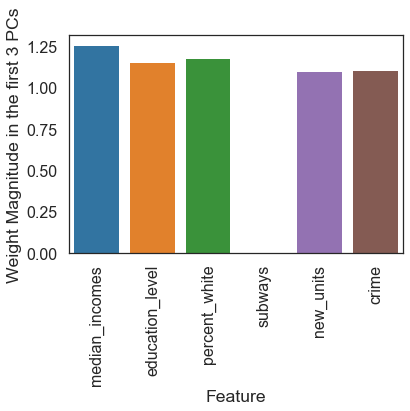

In [167]:
ax = sns.barplot(x = feature_labels, y = abs(pcas)[:,:3].sum(axis=1).mean(axis=0))
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Total Weight Magnitude in the first 3 PCs')
plt.show()

So we conclude that our proportion of subways data is irrelevant and discard it

## Lagging
### Temporal
For time series data, a common practice is to _lag_ the data with itself by comparing current values of the data with past values, as the current value depends on the past value. The way we will do this first is by computing the _Exponential Moving Average_ ($S_t$) for all of the median rents, where $S_t$ is defined recursively as
$$ S_t = \begin{cases} 
Y_1 & t = 0 \\ 
\frac{1}{1 + c} Y_t + \frac{c}{1+c} S_{t-1} & t > 0 
\end{cases} $$
$c$ being the center of mass of the moving average, which we chose as $2$, and adding it as a feature:

In [113]:
ema = median_rents[years].ewm(com=2).mean().values

In [168]:
n = 12 # number of years
m = 6 # number of features
k = 55 # number of PUMAs
years = [str(y) for y in range(2005,2017)]

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, new_units[years].values, crime[years].values, ema]
feature_labels = ['median_incomes','education_level', 'percent_white', 'new_units', 'crime', 'ema']

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

X = np.dstack(features)    
    
Y = median_rents[years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))

X_test = X[:,-2:,:]
Y_test = Y[:,-2:]
Y_train = Y[:,:-2]
X_train = X[:, :-2, :]

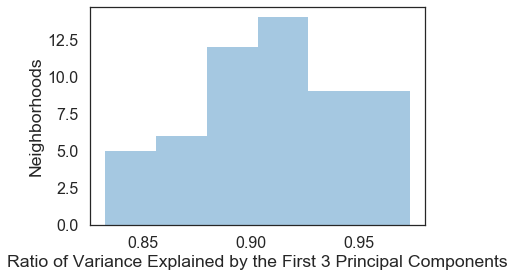

In [170]:
pcas = np.zeros((k,m,m))
expratios = np.zeros((k,m))
pca = PCA()
for i in range(k):
    pca = pca.fit(X_train[i], Y_train[i])
    pcas[i] = pca.components_
    expratios[i] = pca.explained_variance_ratio_
sns.distplot(expratios[:,:3].sum(axis=1), kde=False)
plt.xlabel('Ratio of Variance Explained by the First 3 Principal Components')
plt.ylabel('Neighborhoods')
plt.show()

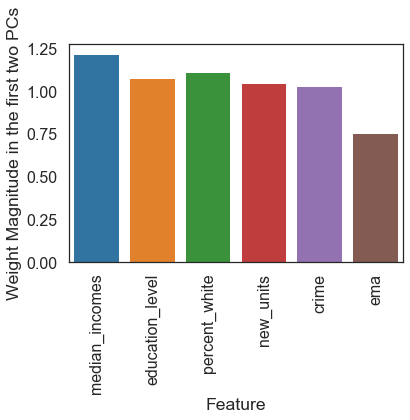

In [171]:
ax = sns.barplot(x = feature_labels, y = abs(pcas)[:,:3].sum(axis=1).mean(axis=0))
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Total Weight Magnitude in the first 3 PCs')
plt.show()

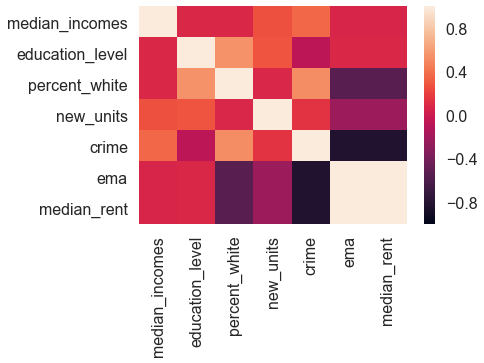

In [117]:
Cs = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
for i in range(1,k):
    m = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
    Cs=np.dstack([Cs,m])
sns.heatmap(Cs.mean(axis=2), xticklabels = feature_labels+['median_rent'], yticklabels = feature_labels + ['median_rent'], vmin = -1, vmax =1)
plt.show()

## Spatial
We believed that the spatial component of rent prices is is important as well, and wanted to include it as a feature. To do so, we used the _spatial lag_ $W Y_i$, where $W$ is a weight matrix relating the neighborhoods to each other in space. In the simplest case, $W$ is a stochastic matrix of first-degree neighbors, and $W Y_i$ is the mean rent of all of the neighborhoods surrounding neighborhood $i$. To get this information, we found a map file for all of the PUMAs in New York City

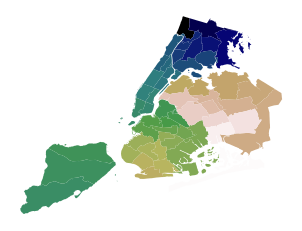

In [119]:
sns.set_style("white")
sbas = gpd.read_file('../data/Public Use Microdata Areas (PUMA)/')
sbas['puma'] = sbas['puma'].astype('int64')
sbas = sbas.merge(puma_cd_name, on='puma')
sbas['cd'] = sbas['cd'].str.replace(" ","")
ax = sbas.plot(cmap='gist_earth')
sns.despine(top=True, left=True, right= True, bottom=True)
ax.set(xticklabels=[],yticklabels=[])
plt.show()

And generated a network connecting first-degree neighbors

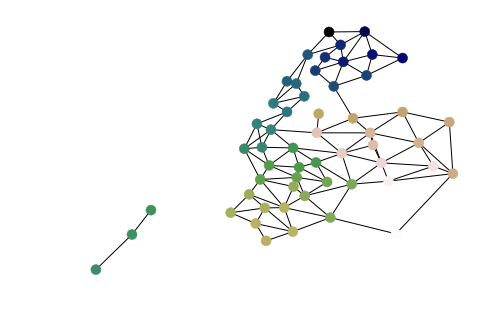

In [120]:
G = nx.Graph()
G.add_nodes_from(sbas.index)
n = len(sbas.index)
for i,row in sbas.iterrows():
    for j in range(i+1,n):
        if row['geometry'].touches(sbas.loc[j]['geometry']):
            dist = row['geometry'].centroid.distance(sbas.loc[j]['geometry'].centroid) 
            G.add_edge(i,j, weight=dist)
nx.draw(G, pos = sbas['geometry'].centroid.map(lambda p: (p.x,p.y)).to_dict(), node_size=100, node_color=range(n), cmap=plt.cm.gist_earth)
plt.show()

$W$ is then

In [121]:
W = np.ceil(nx.to_numpy_matrix(G))
for i, row in enumerate(W):
    W[i] = row / row.sum()
W

matrix([[ 0.        ,  0.33333333,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.2       ,  0.        ,  0.2       , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.33333333,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.25      ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.25      ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [146]:
columns = ['cd'] + years
spatial_lag1 = pd.DataFrame()
for v in G.nodes():
    puma = sbas.iloc[v]['puma']
    neighbors = G[v].keys()
    neighbor_cds = list(sbas.iloc[neighbors]['cd'])
    rent_rows = median_rents[median_rents['cd'].isin(neighbor_cds)][columns]
    Wyi = rent_rows.mean()
    Wyi['puma'] = puma
    spatial_lag1 = spatial_lag1.append(Wyi, ignore_index=True)
spatial_lag1['puma'] = spatial_lag1['puma'].astype('int')
spatial_lag1 = spatial_lag1.set_index('puma')
spatial_lag1 = spatial_lag1.sort_index()

In [172]:
n = 12 # number of years
m = 7 # number of features
k = 55 # number of PUMAs

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, new_units[years].values, crime[years].values, spatial_lag1, ema] 
feature_labels = ['median_incomes', 'education_level', 'percent_white', 'new_units', 'crime', 'spatial_lag','ema']

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

X = np.dstack(features)    
    
Y = median_rents[years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))

X_test = X[:,-2:,:]
Y_test = Y[:,-2:]
Y_train = Y[:,:-2]
X_train = X[:, :-2, :]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


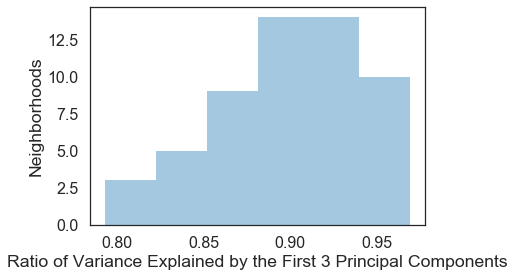

In [173]:
pcas = np.zeros((k,m,m))
expratios = np.zeros((k,m))
pca = PCA()
for i in range(k):
    pca = pca.fit(X_train[i], Y_train[i])
    pcas[i] = pca.components_
    expratios[i] = pca.explained_variance_ratio_
sns.distplot(expratios[:,:3].sum(axis=1), kde=False)
plt.xlabel('Ratio of Variance Explained by the First 3 Principal Components')
plt.ylabel('Neighborhoods')
plt.show()

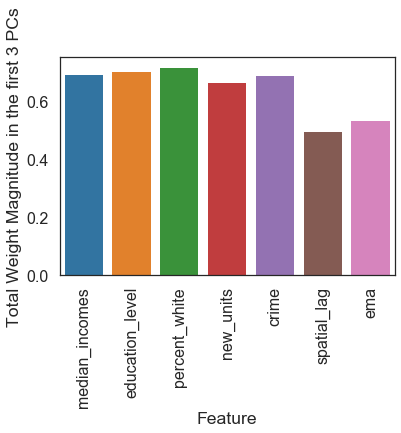

In [176]:
ax = sns.barplot(x = feature_labels, y = abs(pcas)[:,:2].sum(axis=1).mean(axis=0))
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Total Weight Magnitude in the first 3 PCs')
plt.show()

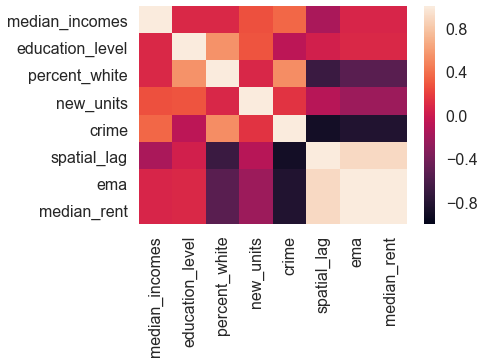

In [192]:
Cs = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
for i in range(1,k):
    m = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
    Cs=np.dstack([Cs,m])
sns.heatmap(Cs.mean(axis=2), xticklabels = feature_labels+['median_rent'], yticklabels = feature_labels + ['median_rent'], vmin = -1, vmax =1)
plt.show()

So the first-degree spatial lag correlates strongly with median rent

# Model 1: Linear Regression

Using our features, we set up a simple linear regression problem
$$ \mathbf{Y}_i = \mathbf{X}_i \theta_i + \epsilon_i$$
for each neighborhood $i$. We trained our linear model on the first 10 years, reserving the last two for testing.

In [182]:
clf = linear_model.LinearRegression()
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residslin2 = np.zeros(k)
for i in range(k):
    clf = clf.fit(X_train[i], Y_train[i])
    predictions[i,:] = clf.predict(X_test[i,:])
    rvals[i] = clf.score(X_train[i], Y_train[i])
    mses[i] = mean_squared_error(Y[i], clf.predict(X[i]))
    residslin2[i] = Y_test[i,1] - clf.predict(X_test[i,1].reshape(1, -1))

We measured the mean-squared error of our fit for every neighborhood:

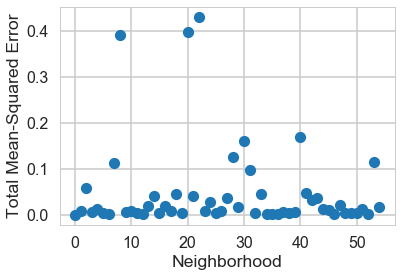

In [188]:
plt.plot(mses, 'o')
plt.xlabel('Neighborhood')
plt.ylabel('Total Mean-Squared Error')
plt.show()

As well as the residuals for predicting median rents in 2016

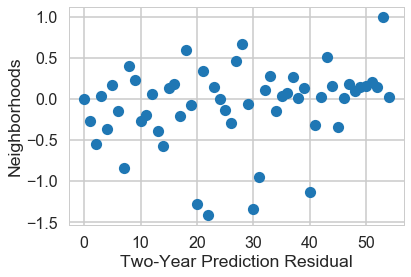

In [191]:
plt.plot(residslin2, 'o')
plt.ylabel('Neighborhoods')
plt.xlabel('Two-Year Linear Regression Residual')
plt.show()

# Model 2: Decision Tree Regression
The next model we used is a decision tree regressor. Given $\mathcal{D} = (\mathbf{X}_i, Y_i)_{i=0}^{n}, \ X_i \in \mathbb{R}^{p}$, $Y_{i} \in \mathbb{R}$ the decision tree regressor iterates through the $p$ features to find a _decision rule_ $(j,a), j \in {1, \dots, p}$ that partitions $\mathcal{D}$ into two disjoint subsets, $\mathcal{D}_{x_j \leq a} \equiv (X^Y,Y^Y)$ and $\mathcal{D}_{x_j > a} \equiv (\mathbf{X}^N, Y^N)$, where $x_j$ is the $j$\textsuperscript{th} feature defining a split of the data into two subsets, $\mathcal{D}_{x_j \leq a}(\mathbf{X}, Y) \equiv (\mathbf{X}^Y, Y^Y)$ and $\mathcal{D}_{x_j > a}(\mathbf{X}, Y)\equiv (\mathbf{X}^N, Y^N)$, where $x_j$ is one of the values of the features in $\mathbf{X}$. $(j,a)$
$$(j,a) = \text{argmin}_{\mathcal{D}_{x_k \leq b}} \sum_{y \in Y^Y} (y - \bar{Y}^Y)^2 + \sum_{y \in Y^N} (y - \bar{Y}^N)^2$$
Where $\bar{Y}^Y$ and $\bar{Y}^N$ are the means of the two subsets, respectively. This process is then repeated on $(X^Y,Y^Y)$ and $(Y^N,Y^N)$ recursively until some end condition is met. In the case of our regression, the end condition was that no more splitting could be performed. Classification is performed by following the decision rules to a leaf and returning the mean value at that leaf.

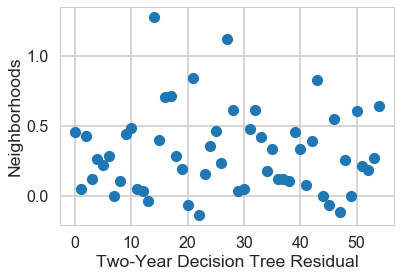

In [197]:
residstree = np.zeros(k)
for i in range(k):
    regr = tree.DecisionTreeRegressor()
    regr.fit(X_train[i], Y_train[i])
    rvals[i] = regr.score(X[i],Y[i])
    residstree[i] = Y_test[i,1] - regr.predict(X_test[i,1].reshape(1, -1))
plt.plot(residstree, 'o')
plt.ylabel('Neighborhoods')
plt.xlabel('Two-Year Decision Tree Residual')
plt.show()

In general, this model had smaller residuals than did our linear regression. However, it systematically underestimated 2016's rent for each neighborhood.

# Model 3: Random Forest Regression

Random forest regression uses $T$ decision trees in parallel. Rather than training on all the data, however, each of the trees is a trained on a subset of size $n$ drawn from the data with replacement. In addition, at each node a random subset of up to $m$ features is considered to perform the split. We used $T=10$ and $m=p$.

In [201]:
residsfrst = np.zeros(k)
for i in range(k):
    regr = RandomForestRegressor()
    regr.fit(X_train[i], Y_train[i])
    rvals[i] = regr.score(X_test[i],Y_test[i])
    residsfrst[i] = Y_test[i,1] - regr.predict(X_test[i,1].reshape(1, -1))

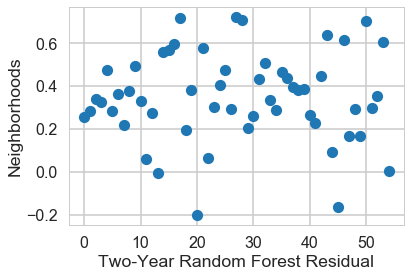

In [204]:
plt.plot(residsfrst, 'o')
plt.ylabel('Neighborhoods')
plt.xlabel('Two-Year Random Forest Residual')
plt.show()

# Model 5: LSTM (add citation)

Finally, we tried to predict median rents using a long-short term memory (LSTM) network. Recurrent neural networks (RNNs) are structured to handle dynamic data such as time series. We can represent an RNN with: 

ht=σ(Uxt+Vht−1)  

where U is the weight matrix of the inputs and V is the weight matrix of the recurrent outputs. However, RNNs do not generalize well to evaluations of longer time series, due to the high potential of a vanishing gradient as our number of time steps increases. LSTMs handle the vanishing gradient problem by introducing the LSTM cell, which adds an internal memory state to the processed input. LSTM cells modulate processing with 3 gates: an input gate, an output gate, and a forget gate. 

The input is first restricted to values between -1 and 1: 

g = tanh(bg+xtUg+ht−1Vg)

where Ug is the weight of the input, Vg is the weight of the previous cell output, and bg is the input bias.
The output of the input gate is g∘i, where i = σ(bi+xtUi+ht−1Vi).

The internal memory of the LSTM cell is contained in state st, which is lagged by one. This is passed through the forget gate, which determines which previous states to remember. This is all added to the input (as discussed above).
The output of the forget gate is then 

st=st−1∘f+g∘i, where f=σ(bf+xtUf+ht−1Vf). 

The output gate of the LSTM cell then returns 

ht=tanh(st)∘o, where o=σ(bo+xtUo+ht−1Vo)